<a href="https://colab.research.google.com/github/adammoss/bnn_hmc/blob/main/results/CMD_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import shutil
import subprocess
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
!nvidia-smi

Tue Aug 23 18:15:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    50W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install astro-datasets --upgrade
!pip install tensorflow_datasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
shutil.rmtree('bnn_hmc', ignore_errors=True)

In [5]:
!git clone https://github.com/adammoss/bnn_hmc

Cloning into 'bnn_hmc'...
remote: Enumerating objects: 491, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 491 (delta 144), reused 93 (delta 58), pack-reused 288
Receiving objects: 100% (491/491), 943.70 KiB | 18.15 MiB/s, done.
Resolving deltas: 100% (338/338), done.


In [6]:
# https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.65+cuda111-cp37-none-manylinux2010_x86_64.whl
!pip install jax==0.2.12
!pip install dm-haiku==0.0.5.dev0 optax==0.0.6 chex==0.0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.65+cuda111-cp37-none-manylinux2010_x86_64.whl (189.4 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
for i, root in enumerate(glob.glob('/content/runs/*/')):
  shutil.rmtree(root, ignore_errors=True)

In [8]:
!python3 bnn_hmc/scripts/run_vi.py --seed=1 --weight_decay=5. --dir=runs/vi/cmd/ \
  --dataset_name=cmd --model_name=lenet --scaling=asinh --image_size=64 \
  --init_step_size=1e-4 --num_epochs=200 --eval_freq=5 --batch_size=100 --patience 20\
  --save_freq=300 --optimizer=Adam --builder_kwargs='{"simulation": "IllustrisTNG", "field": "Mtot", "parameters": ["omegam"]}' \
  --vi_sigma_init=0.01 --temperature=1. --vi_ensemble_size=20 --train_split=train[:90%] --test_split=train[90%:95%]

JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Starting from random initialization with provided seed
/content/bnn_hmc/bnn_hmc/utils/script_utils.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predict_fn(net_apply, params, net_state, test_set))
/content/bnn_hmc/bnn_hmc/utils/script_utils.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predict_fn(net_apply, params, net_state, train_set))
bnn_hmc/scripts/run_vi.py:199: Visi

In [9]:
!python3 bnn_hmc/scripts/run_vi.py --seed=1 --weight_decay=5. --dir=runs/vi/cmd/ \
  --dataset_name=cmd --model_name=lenet --scaling=asinh --image_size=64 \
  --init_step_size=1e-4 --num_epochs=200 --eval_freq=5 --batch_size=100 --patience 20\
  --save_freq=300 --optimizer=Adam --builder_kwargs='{"simulation": "IllustrisTNG", "field": "Mtot", "parameters": ["omegam"]}' \
  --vi_sigma_init=0.01 --temperature=1. --vi_ensemble_size=20 --eval_split=train[95%:]

JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Continuing the run from the last saved checkpoint
bnn_hmc/scripts/run_vi.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vi_ensemble_predict_fn(net_apply, params, net_state, test_set))
{'scaled_nll': -1.3476083278656006, 'scaled_mse': 0.0037258071824908257, 'scaled_rmse': 0.061039390417097265, 'nll': -1.3476083278656006, 'mse': 0.0037258071824908257, 'rmse': 0.061039390417097265}


In [14]:
accuracies = []
nlls = []
eces = []
softmax = []
for i, root in enumerate(glob.glob('/content/runs/vi/cmd/*/')):
  data = np.load(root + '/test_set.npy')  
  predictions = np.squeeze(np.load(root + '/predictions.npy'))[:,:,0]
  errors = np.squeeze(np.load(root + '/predictions.npy'))[:,:,1]
  metrics = np.load(root + '/metrics.npy', allow_pickle=True)
  print(metrics)

{'scaled_nll': -1.3476083278656006, 'scaled_mse': 0.0037258071824908257, 'scaled_rmse': 0.061039390417097265, 'nll': -1.3476083278656006, 'mse': 0.0037258071824908257, 'rmse': 0.061039390417097265}


In [15]:
mean_predictions = np.mean(predictions, axis=0)
mean_errors = np.std(errors, axis=0)
total_errors = (mean_errors**2 + np.std(predictions, axis=0)**2)**0.5
diffs = mean_predictions - data[0,:,0]

In [16]:
print('Ensemble MSE', np.mean(diffs**2))
print('Ensemble MAE', np.mean(np.abs(diffs)))

Ensemble MSE 0.0037258072
Ensemble MAE 0.049060144


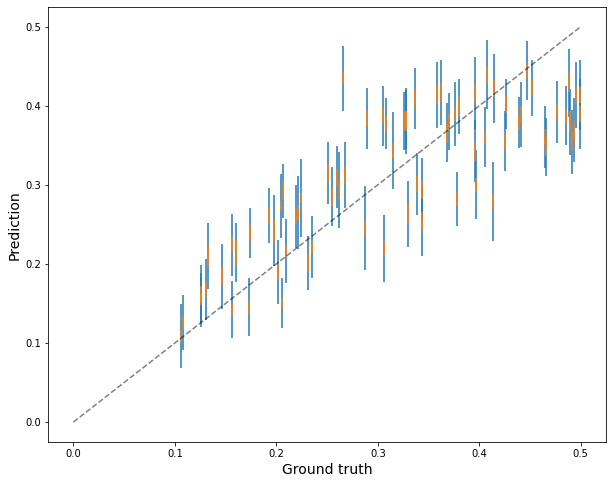

In [17]:
plt.figure(figsize=(10,8))
plt.errorbar(data[0,::10,0], mean_predictions[::10], total_errors[::10],  ls='none')
plt.errorbar(data[0,::10,0], mean_predictions[::10], mean_errors[::10],  ls='none')
plt.plot(np.linspace(0,0.5,10), np.linspace(0,0.5,10), linestyle='--', color='black', alpha=0.5)
plt.xlabel('Ground truth', fontsize=14)
plt.ylabel('Prediction', fontsize=14)
plt.show()